# AI SFX Pipeline

This notebook is a prototype for generating sound effects using ElevenLabs API.

## Loading Libraries and setting up clients

In [69]:
import os
from dotenv import load_dotenv
from elevenlabs.client import ElevenLabs
import logging
import base64
import json
from typing import Any, Dict
import boto3
from IPython.display import Image, HTML, display, Audio
from string import Template


fmt = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

# 2. Create console handler (to send logs to Jupyter's stdout)
console_handler = logging.StreamHandler()
console_handler.setFormatter(fmt)

# 3. Create and configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

if not logger.hasHandlers():
    logger.addHandler(console_handler)

load_dotenv()

# Constants
OUTPUT_FOLDER = "../output"
AWS_REGION = "eu-west-1"

# 3rd Party Clients
aws_bedrock = boto3.client("bedrock-runtime", region_name=AWS_REGION)

elevenlabs = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)


## LLM Prompts

In [63]:
# Prompts refined w/ ChatGPT 5

IMAGE_DESCRIPTION_PROMPT = """
ROLE: You are an expert image describer trained to identify and concisely describe the main physical object in an image for the purpose of sound design.

CONTEXT:
Your descriptions will later be used to generate sound effects (SFX). Therefore, focus only on the object(s) or surface(s) that have distinct physical materials or textures that could produce sound when interacted with (e.g., walked on, hit, rubbed, etc.).

TASK:
1. Identify the single main object or surface in the image.
2. Describe it briefly (one short sentence, max 20 words).
3. Include its key materials or textures (e.g., leather, wood, sand, metal, glass, fabric).
4. Ignore secondary elements, background scenery, lighting, or artistic details.

OUTPUT FORMAT:
Return only the plain text description — no prefixes, labels, or extra commentary.

EXAMPLES:
- "a pair of leather shoes with rubber soles"
- "fine dry sand on a beach surface"
- "a solid wooden dining table"
- "a shiny metal frying pan"
- "a thick wool sweater"

GOAL:
Produce a short, accurate, material-focused description suitable for later use in sound generation models.
"""

ACTION_COMBINATION_PROMPT = Template("""
ROLE:
You are a professional sound designer who writes short, vivid descriptions of sound effects for use in audio generation models.

CONTEXT:
You will receive short text descriptions of two elements and an action that connects them.
These descriptions were generated by another system that analyzed images.
You will NOT see any images. Your only input is text.
Your goal is to combine these inputs into a natural, realistic description of what the resulting sound would be like.

TASK:
1. Combine the inputs into one or two short sentences (no more than 40 words in total).
2. Focus entirely on what the listener would hear.
3. Describe acoustic properties such as:
   - materials and how they interact (impact, friction, resonance)
   - texture or timbre (soft, metallic, crunchy, etc.)
   - rhythm, intensity, and environment (echo, outdoor, muffled, etc.)
4. Avoid visual, narrative, or emotional phrasing. Output must be purely auditory and concise.

INPUT:
- element_a: "$element_a"
- action: "$action"
- element_b: "$element_b"

OUTPUT REQUIREMENTS:
Return only the final sound description as plain text.
Do not include labels, headings, or explanations.

EXAMPLES:
Example 1:
element_a: "a pair of leather boots with rubber soles"
action: "walking on"
element_b: "fine dry sand on a beach"

Expected output:
"Soft, rhythmic footsteps of leather boots crunching over dry beach sand, slightly muffled by the grains."

Example 2:
element_a: "a steel sword"
action: "clashing against"
element_b: "an iron axe"

Expected output:
"A loud metallic clash as a steel sword strikes an iron axe, followed by a brief, high-pitched ringing echo."

RETURN:
Only the final sound description as plain text.
""")




## Helper Functions

In [78]:
def generate_sfx(prompt:str, duration:int, filename:str, loop:bool=False):
    """
    Generate a sound effect using ElevenLabs text-to-sound-effects API and save it to a file.

    :param prompt:
    :param duration:
    :param filename:
    :param loop:
    :return:
    """

    output_file_path = f"{OUTPUT_FOLDER}/{filename}"

    logger.info(f"Generating sound effect: '{prompt}' for '{duration}' seconds. Saving to '{output_file_path}'")

    audio = elevenlabs.text_to_sound_effects.convert(
        text=prompt,
        duration_seconds=duration,
        loop=loop,
    )

    # making sure file ends in mp3
    if not filename.endswith(".mp3"):
        filename += ".mp3"

    with open(output_file_path, "wb") as f:
        for chunk in audio:
            if chunk:
                f.write(chunk)


def describe_image(
    image_path: str,
    model_id: str = "eu.amazon.nova-lite-v1:0",
    max_tokens: int = 200,
    temperature: float = 0.2
) -> str:
    """
    Bases64-encode the image and send it to a model to describe it.
    Returns a plain string
    """
     # 1) Base64
    with open(image_path, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode("utf-8")

    # 2) Determine image format for Nova ("png" or "jpeg")
    ext = image_path.lower().rsplit(".", 1)[-1]
    if ext == "jpg":
        ext = "jpeg"
    if ext not in {"png", "jpeg"}:
        ext = "jpeg"

    # 3) Build Nova request (NO Anthropic-style "type" keys)
    payload: Dict[str, Any] = {
        "schemaVersion": "messages-v1",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "image": {
                            "format": ext,
                            "source": {"bytes": image_b64}  # Base64 string for InvokeModel
                        }
                    },
                    {"text": IMAGE_DESCRIPTION_PROMPT},
                ],
            }
        ],
        "inferenceConfig": {
            "maxTokens": max_tokens,
            "temperature": temperature,
            # Optional: "topP": 0.9, "topK": 50
        },
        # Optional:
        # "system": [{"text": "You are an expert image describer for SFX material cues."}]
    }

    # 4) Invoke
    resp = aws_bedrock.invoke_model(
        modelId=model_id,
        body=json.dumps(payload),
        accept="application/json",
        contentType="application/json",
    )

    # 5) Parse
    body = resp.get("body")
    if not body:
        raise RuntimeError("Empty response body from Bedrock.")
    parsed = json.loads(body.read().decode("utf-8"))

    # Nova response: output.message.content -> [{ "text": "..."} , ...]
    try:
        content = parsed["output"]["message"]["content"]
        if isinstance(content, list) and len(content) > 0:
            text = content[0].get("text", "")
            return text.strip(' "')
    except (KeyError, TypeError):
        pass

    return json.dumps(parsed, ensure_ascii=False, indent=2)



def describe_sfx(
    prompt: str,
    model_id: str = "eu.amazon.nova-lite-v1:0",
    max_tokens: int = 200,
    temperature: float = 0.2
) -> str:

    # 3) Build Nova request (NO Anthropic-style "type" keys)
    payload: Dict[str, Any] = {
        "schemaVersion": "messages-v1",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"text": prompt},
                ],
            }
        ],
        "inferenceConfig": {
            "maxTokens": max_tokens,
            "temperature": temperature,
        },
    }

    # 4) Invoke
    resp = aws_bedrock.invoke_model(
        modelId=model_id,
        body=json.dumps(payload),
        accept="application/json",
        contentType="application/json",
    )

    # 5) Parse
    body = resp.get("body")
    if not body:
        raise RuntimeError("Empty response body from Bedrock.")
    parsed = json.loads(body.read().decode("utf-8"))

    # Nova response: output.message.content -> [{ "text": "..."} , ...]
    try:
        content = parsed["output"]["message"]["content"]
        if isinstance(content, list) and len(content) > 0:
            text = content[0].get("text", "")
            return text.strip(' "')
    except (KeyError, TypeError):
        pass

    return json.dumps(parsed, ensure_ascii=False, indent=2)


def display_sfx_pipeline(
    image_1_path: str,
    image_2_path: str,
    description_1: str,
    description_2: str,
    action: str,
    sfx_description: str,
    audio_file_path: str
):

    display(HTML(f"""
    <div style="display: flex; align-items: center; gap: 20px; margin: 20px 0;">
        <div style="text-align: center;">
            <p style="font-weight: bold;">Image 1</p>
            <img src="{image_1_path}" style="max-width: 150px; border: 1px solid #ccc; border-radius: 5px;">
            <p style="font-size: 0.9em; margin-top: 10px;"><code>{description_1}</code></p>
        </div>

        <div style="font-size: 24px; font-weight: bold;">+</div>

        <div style="text-align: center;">
            <p style="font-weight: bold;">Action</p>
            <p style="font-size: 18px; padding: 10px; background: #f0f0f0; border-radius: 5px;">{action}</p>
        </div>

        <div style="font-size: 24px; font-weight: bold;">+</div>

        <div style="text-align: center;">
            <p style="font-weight: bold;">Image 2</p>
            <img src="{image_2_path}" style="max-width: 150px; border: 1px solid #ccc; border-radius: 5px;">
            <p style="font-size: 0.9em; margin-top: 10px;"><code>{description_2}</code></p>
        </div>

        <div style="font-size: 24px; font-weight: bold;">=</div>

        <div style="text-align: center;">
            <p style="font-weight: bold;">Sound Effect</p>
            <p style="font-size: 0.9em; margin: 10px 0;"><code>{sfx_description}</code></p>
        </div>
    </div>
    """))

    if os.path.exists(audio_file_path):
        display(Audio(audio_file_path))


def generate_sfx_pipeline(
    image_1_path: str,
    image_2_path: str,
    action: str,
    sfx_name: str,
    duration: int = 3,
    model_id: str = "eu.amazon.nova-lite-v1:0"
):
    """
    Complete SFX generation pipeline: describe images, combine with action, generate audio, and display.

    :param image_1_path: Path to first image
    :param image_2_path: Path to second image
    :param action: Action connecting the two elements
    :param sfx_name: Output filename for the generated SFX
    :param duration: Duration in seconds for the generated audio
    :param model_id: Bedrock model ID to use
    """
    logger.info("Starting SFX Generation Pipeline")

    # Describe both images
    logger.info("Describing images...")
    description_1 = describe_image(image_1_path, model_id=model_id)
    logger.info(f"Image 1 description: `{description_1}`")

    description_2 = describe_image(image_2_path, model_id=model_id)
    logger.info(f"Image 2 description: `{description_2}`")

    # Generate SFX description
    logger.info("Combining descriptions with action...")
    prompt = ACTION_COMBINATION_PROMPT.substitute(
        element_a=description_1,
        action=action,
        element_b=description_2
    )

    sfx_description = describe_sfx(prompt, model_id=model_id)
    logger.info(f"Final SFX Description: `{sfx_description}`")

    # Generate audio
    logger.info(f"Generating audio ({duration}s)...")
    generate_sfx(sfx_description, duration=duration, filename=sfx_name)

    # Display pipeline visualization

    display_sfx_pipeline(
        image_1_path=image_1_path,
        image_2_path=image_2_path,
        description_1=description_1,
        description_2=description_2,
        action=action,
        sfx_description=sfx_description,
        audio_file_path=f"{OUTPUT_FOLDER}/{sfx_name}"
    )


## Main Application

### Input Details
Here you define the input images and the action that link the 2 images together. Image 1 does "ACTION" on Image 2.

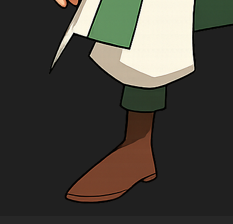

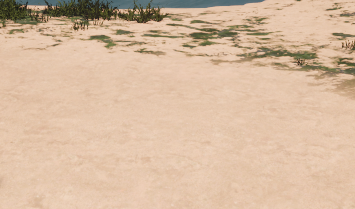

In [80]:
IMAGE_1 = "../input/element-1.png"
IMAGE_2 = "../input/terrain-1.png"
ACTION = "Footsteps"

SFX_NAME = "sfx-attempt-1.mp3"
SFX_DURATION = 3 # seconds

display(Image(filename=IMAGE_1))
display(Image(filename=IMAGE_2))

### Here we describe both images using the Bedrock model
- 2 calls to `describe_image()`
- 1 call to `describe_sfx()` (combining both descriptions with the action)

In [81]:
description_1 = describe_image(IMAGE_1)
logger.info(f"Image 1 description: `{description_1}`")

description_2 = describe_image(IMAGE_2)
logger.info(f"Image 2 description: `{description_2}`")

2025-10-26 23:02:40,233 - __main__ - INFO - Image 1 description: `a pair of brown leather shoes with rubber soles`
2025-10-26 23:02:40,829 - __main__ - INFO - Image 2 description: `fine dry sand on a beach surface`


In [83]:
prompt = ACTION_COMBINATION_PROMPT.substitute(
    element_a=description_1,
    action=ACTION,
    element_b=description_2
)

sfx_description = describe_sfx(prompt)

logger.info(f"Final SFX Description: `{sfx_description}`")

2025-10-26 23:02:48,810 - __main__ - INFO - Final SFX Description: `Soft, rhythmic footsteps of brown leather shoes with rubber soles crunching over fine, dry beach sand, each step leaving a faint imprint.`


### Finally, we generate the sound effect using ElevenLabs API


In [84]:
generate_sfx(sfx_description, duration=SFX_DURATION, filename=SFX_NAME)

2025-10-26 23:02:52,823 - __main__ - INFO - Generating sound effect: 'Soft, rhythmic footsteps of brown leather shoes with rubber soles crunching over fine, dry beach sand, each step leaving a faint imprint.' for '3' seconds. Saving to '../output/sfx-attempt-1.mp3'


In [85]:
display_sfx_pipeline(
    image_1_path=IMAGE_1,
    image_2_path=IMAGE_2,
    description_1=description_1,
    description_2=description_2,
    action=ACTION,
    sfx_description=sfx_description,
    audio_file_path=f"{OUTPUT_FOLDER}/{SFX_NAME}"
)


## Some Custom Generations

In [86]:
generate_sfx_pipeline(
    image_1_path="../input/element-1.png",
    image_2_path="../input/terrain-2.png",
    action="walking on",
    sfx_name="sfx-2.mp3",
    duration=2
)

2025-10-26 23:03:12,552 - __main__ - INFO - Starting SFX Generation Pipeline
2025-10-26 23:03:12,553 - __main__ - INFO - Describing images...
2025-10-26 23:03:13,086 - __main__ - INFO - Image 1 description: `a pair of brown leather shoes with rubber soles`
2025-10-26 23:03:13,716 - __main__ - INFO - Image 2 description: `rough rocky terrain with patches of sparse vegetation`
2025-10-26 23:03:13,717 - __main__ - INFO - Combining descriptions with action...
2025-10-26 23:03:14,127 - __main__ - INFO - Final SFX Description: `Crunching leather soles against rocky terrain, interspersed with the occasional rustle of sparse vegetation.`
2025-10-26 23:03:14,128 - __main__ - INFO - Generating audio (2s)...
2025-10-26 23:03:14,128 - __main__ - INFO - Generating sound effect: 'Crunching leather soles against rocky terrain, interspersed with the occasional rustle of sparse vegetation.' for '2' seconds. Saving to '../output/sfx-2.mp3'


In [87]:
generate_sfx_pipeline(
    image_1_path="../input/element-1.png",
    image_2_path="../input/terrain-3.png",
    action="footsteps",
    sfx_name="sfx-3.mp3",
    duration=3
)

2025-10-26 23:03:48,428 - __main__ - INFO - Starting SFX Generation Pipeline
2025-10-26 23:03:48,429 - __main__ - INFO - Describing images...
2025-10-26 23:03:48,880 - __main__ - INFO - Image 1 description: `a pair of brown leather boots`
2025-10-26 23:03:49,330 - __main__ - INFO - Image 2 description: `a sandy beach shore with small pebbles`
2025-10-26 23:03:49,331 - __main__ - INFO - Combining descriptions with action...
2025-10-26 23:03:49,706 - __main__ - INFO - Final SFX Description: `Crunchy, rhythmic footsteps of brown leather boots pressing into sandy beach shore, pebbles shifting with each step.`
2025-10-26 23:03:49,707 - __main__ - INFO - Generating audio (3s)...
2025-10-26 23:03:49,707 - __main__ - INFO - Generating sound effect: 'Crunchy, rhythmic footsteps of brown leather boots pressing into sandy beach shore, pebbles shifting with each step.' for '3' seconds. Saving to '../output/sfx-3.mp3'


In [93]:
generate_sfx_pipeline(
    image_1_path="../input/element-1.png",
    image_2_path="../input/terrain-4.png",
    action="footsteps",
    sfx_name="sfx-4.mp3",
    duration=3
)

2025-10-26 23:11:26,573 - __main__ - INFO - Starting SFX Generation Pipeline
2025-10-26 23:11:26,574 - __main__ - INFO - Describing images...
2025-10-26 23:11:26,981 - __main__ - INFO - Image 1 description: `a pair of brown leather shoes with rubber soles`
2025-10-26 23:11:27,693 - __main__ - INFO - Image 2 description: `dense green foliage with rough, woody textures`
2025-10-26 23:11:27,694 - __main__ - INFO - Combining descriptions with action...
2025-10-26 23:11:28,147 - __main__ - INFO - Final SFX Description: `Crunchy, rhythmic footsteps of brown leather shoes with rubber soles, interspersed with the rustling of dense green foliage.`
2025-10-26 23:11:28,147 - __main__ - INFO - Generating audio (3s)...
2025-10-26 23:11:28,148 - __main__ - INFO - Generating sound effect: 'Crunchy, rhythmic footsteps of brown leather shoes with rubber soles, interspersed with the rustling of dense green foliage.' for '3' seconds. Saving to '../output/sfx-4.mp3'


In [92]:
generate_sfx_pipeline(
    image_1_path="../input/element-2.png",
    image_2_path="../input/terrain-4.png",
    action="firing into",
    sfx_name="sfx-5.mp3",
    duration=2
)

2025-10-26 23:10:57,322 - __main__ - INFO - Starting SFX Generation Pipeline
2025-10-26 23:10:57,323 - __main__ - INFO - Describing images...
2025-10-26 23:10:57,966 - __main__ - INFO - Image 1 description: `a large black cannon with wooden wheels and metal chains`
2025-10-26 23:10:58,652 - __main__ - INFO - Image 2 description: `dense green foliage with rough, fibrous textures`
2025-10-26 23:10:58,652 - __main__ - INFO - Combining descriptions with action...
2025-10-26 23:10:59,124 - __main__ - INFO - Final SFX Description: `A deep, resonant boom as a large black cannon fires, followed by the sharp, metallic clink of metal chains and the muted thud of cannonballs piercing dense green foliage.`
2025-10-26 23:10:59,125 - __main__ - INFO - Generating audio (2s)...
2025-10-26 23:10:59,125 - __main__ - INFO - Generating sound effect: 'A deep, resonant boom as a large black cannon fires, followed by the sharp, metallic clink of metal chains and the muted thud of cannonballs piercing dense g